In [2]:
import sys
import numpy as np
from scipy.spatial import ConvexHull
from scipy import sparse
import pandas as pd
from sklearn.manifold import MDS #If you want the scikit learn mds
import hictoolbox
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [3]:
R=100000
NbmaxEpi=15 #Epi states go from 0 to 15
alpha=0.227
selectedmark=1 #index of the selected mark
HiCfilename='data/chr1_100kb.RAWobserved'

# loading matrix
A=np.loadtxt(HiCfilename)
A=np.int_(A)
print('Input data shape : ',np.shape(A))
A=np.concatenate((A,np.transpose(np.array([A[:,1],A[:,0],A[:,2]]))), axis=0)#build array at pb resolution
A = sparse.coo_matrix( (A[:,2], (A[:,0],A[:,1])))
binned_map=hictoolbox.bin2d(A,R,R) #!become csr sparse array
LENTEST=np.shape(A)[0]
print('Input at the good resolution : ',np.shape(binned_map))

del A #keep space

Input data shape :  (2435300, 3)
Input at the good resolution :  (2493, 2493)


In [4]:
# filtering
filtered_map, binsaved = hictoolbox.filteramat(binned_map)

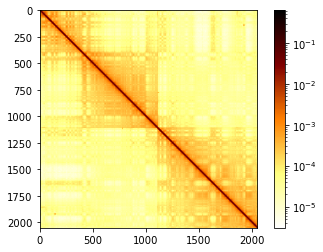

In [21]:
# SCN
D = hictoolbox.SCN(filtered_map)
plt.imshow(D, norm=LogNorm(), cmap='afmhot_r')
plt.colorbar()
plt.show()

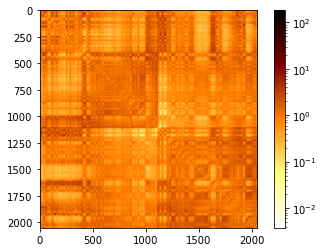

In [22]:
# Observed under expected
D = hictoolbox.observed_expected(D)
plt.imshow(D, norm=LogNorm(), cmap='afmhot_r')
plt.colorbar()
plt.show()

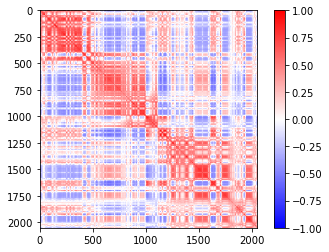

In [24]:
# pearson correlation
D = np.corrcoef(D)
plt.imshow(D, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [25]:
# Extract the first eigenvector on the pearson correlation matrix
from sklearn import decomposition

pca = decomposition.PCA(n_components=1)
res = pca.fit_transform(D)

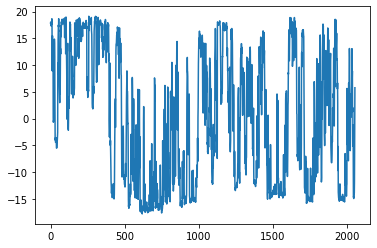

In [26]:
plt.plot(res)
plt.show()

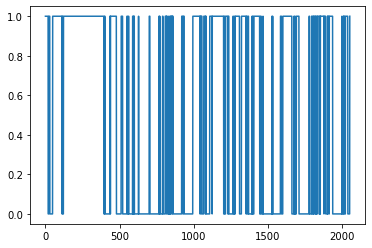

In [27]:
comps = res>0
comps = comps.flatten()
plt.plot(comps)
plt.show()

In [119]:
import matplotlib as mpl

cmap = mpl.colors.ListedColormap(['black', 'blue', 'red'])
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

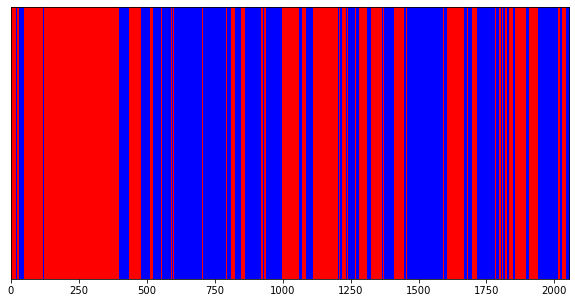

In [136]:
plt.figure(figsize=(20,5))
plt.imshow(np.tile(comps, (1000,1)), cmap=cmap, norm=norm)
plt.yticks([])
plt.show()

In [89]:
c = []
i = 0  # true index
j = 0  # index in comps
while i <= binsaved[-1]:
    if i not in binsaved:
        c.append(-1)
        i+=1
    else:
        if comps[j]:
            c.append(1)
        else:
            c.append(0)
        i+=1
        j+=1
c = c[1:]  # without '0' index

In [90]:
with open('data/chr1_compartiment.txt') as f:
    true_labels = f.readlines()
true_labels = [int(float(i.strip())) for i in true_labels]

In [91]:
c += [-1] * (len(true_labels) - len(c))

In [92]:
c = np.array(c)
true_labels = np.array(true_labels)

In [94]:
np.mean(c==true_labels)

0.9149959903769046

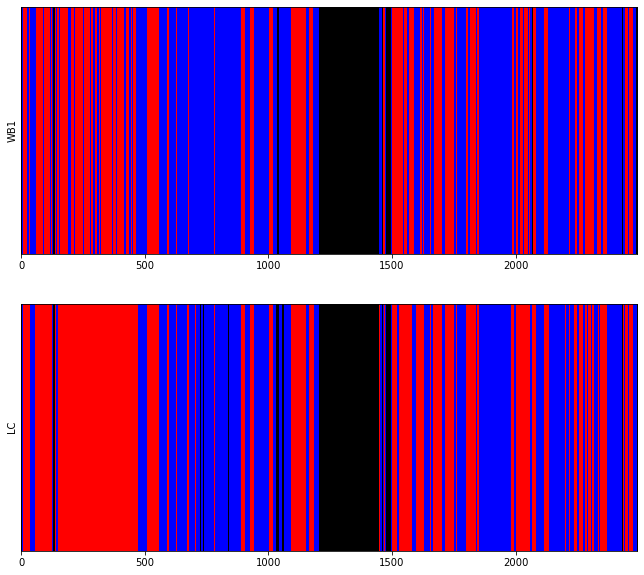

In [121]:
fig, axes = plt.subplots(2, 1, figsize=(20,10))
axes[0].imshow(np.tile(c, (1000,1)), cmap=cmap, norm=norm)
axes[0].set_ylabel('WB1')
axes[0].set_yticks([])
axes[1].imshow(np.tile(true_labels, (1000,1)), cmap=cmap, norm=norm)
axes[1].set_ylabel('LC')
axes[1].set_yticks([])
plt.show()

In [122]:
res_HMM = hictoolbox.makecompartimentbyGaussianHMM(D, N=2)

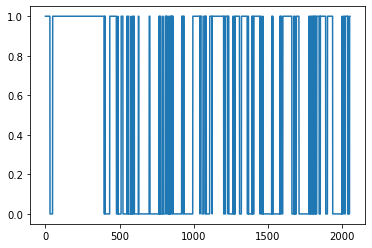

In [123]:
comps_HMM = res_HMM[1]
plt.plot(comps_HMM)
plt.show()

In [124]:
np.mean(comps_HMM==comps)  # zgadzają się w ponad 97%

0.9736970287384316

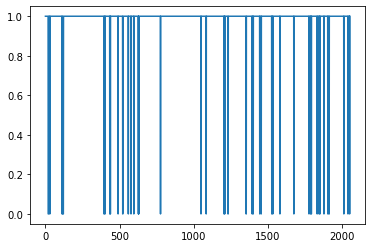

In [125]:
plt.plot(comps_HMM==comps)
plt.show()

In [130]:
c_HMM = []
i = 0  # true index
j = 0  # index in comps
while i <= binsaved[-1]:
    if i not in binsaved:
        c_HMM.append(-1)
        i+=1
    else:
        if comps_HMM[j]:
            c_HMM.append(1)
        else:
            c_HMM.append(0)
        i+=1
        j+=1
c_HMM = c_HMM[1:]  # without '0' index
c_HMM += [-1] * (len(true_labels) - len(c_HMM))

In [132]:
c_HMM = np.array(c_HMM)
np.mean(c_HMM==true_labels)

0.9133921411387329

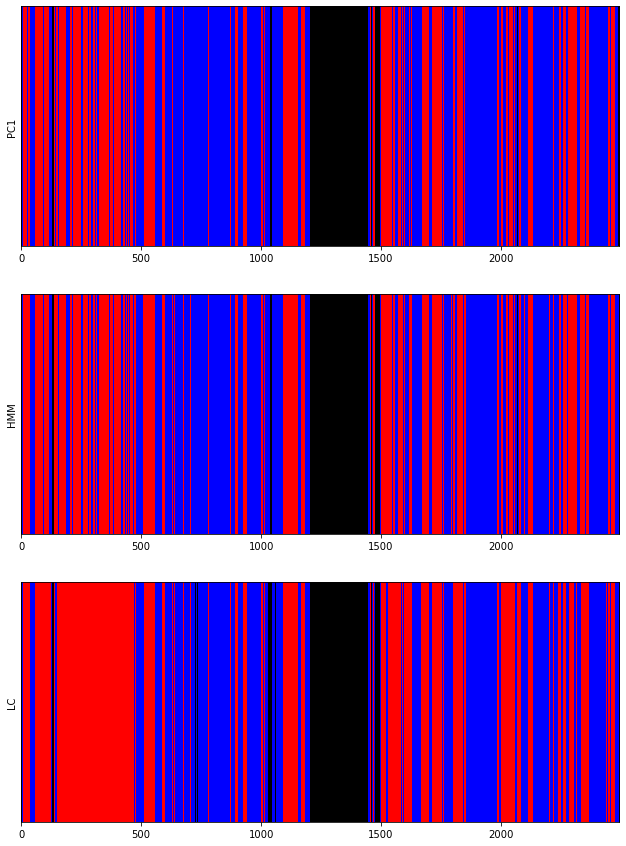

In [135]:
fig, axes = plt.subplots(3, 1, figsize=(20,15))
axes[0].imshow(np.tile(c, (1000,1)), cmap=cmap, norm=norm)
axes[0].set_ylabel('PC1')
axes[0].set_yticks([])
axes[1].imshow(np.tile(c_HMM, (1000,1)), cmap=cmap, norm=norm)
axes[1].set_ylabel('HMM')
axes[1].set_yticks([])
axes[2].imshow(np.tile(true_labels, (1000,1)), cmap=cmap, norm=norm)
axes[2].set_ylabel('LC')
axes[2].set_yticks([])
plt.show()

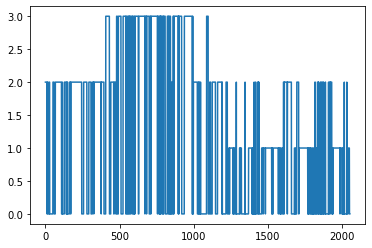

In [151]:
res_HMM3 = hictoolbox.makecompartimentbyGaussianHMM(D, N=3)
comps_HMM3 = res_HMM3[1]
plt.plot(comps_HMM3)
plt.show()

In [136]:
c0 = comps_HMM3==0
c1 = comps_HMM3==1
c2 = comps_HMM3==2
print(np.mean(c0), np.mean(c1), np.mean(c2))

0.5621042377009254 0.21578178275694107 0.22211397954213347


In [130]:
np.mean(c0==comps_HMM)  # stan 0 w N=3 to stan 1 w N=2

0.962493911349245

In [141]:
pca2 = decomposition.PCA(n_components=2)
res2 = pca2.fit_transform(D)

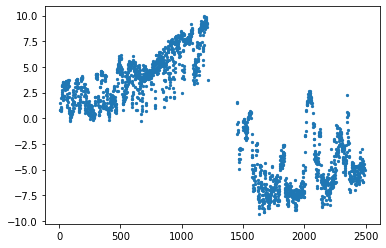

In [145]:
plt.scatter(binsaved, res2[:,1], s=5)
plt.show()

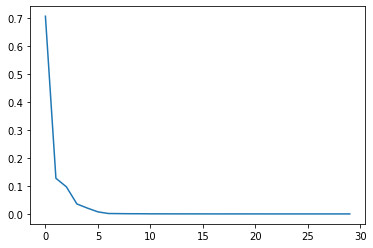

In [150]:
pca2 = decomposition.PCA(n_components=30)
res2 = pca2.fit_transform(D)
plt.plot(pca2.explained_variance_ratio_)
plt.show()